#![ML Logo](https://raw.githubusercontent.com/chicochica10/utad-spark-ml/master/images/utad-spark-ml.1x_Banner_300.png)
# **Análisis de texto y resolución de entidades**
####La resolución de entidades (entity resolution, ER) es un problema clásico pero dificil en la limpieza e integración de datos. En este lab vamos a ver como utilizar Apache Spark para aplicar técnicas de análisis de texto escalables y de resolución de entidades entre dos datasets de productos comerciales.

#### La resolución de entidades (entity resolution -ER- o "[Record linkage][wiki]") es el término que se utiliza en estadística para describir el proceso de unir (join) registros de una fuente de datos con otra que describe la misma entidad. Ésto puede incluir procesos de "desambiguación/enlazado", "detección de duplicados", "deduplicación", "coincidencia de registros", "reconciliación", "identificación de objetos", "integración de datos" ...
#### La resolución de entidades (ER) se refiere a la tarea de encontrar registros en un dataset que hagan referencia a la misma entidad através de diferentes fuentes de datos (por ejemplo, ficheros de datos, libros, websites, bases de datos). La ER es necesaria cuando se unen datasets basados en entidades que pueden o no compartir un identificador común como por ejemplo una clave de base de datos, una URI, un número nacional de identificación... 
[wiki]: https://en.wikipedia.org/wiki/Record_linkage

### Código
#### Para este lab utilizaremos Python básico y transformaciones y acciones de pySpark y la librería de plotting matplotlib.
### Ficheros
#### Los ficheros de datos están sacados del proyecto [metric-learning](https://code.google.com/p/metric-learning/) y están disponibles en:
`utad-spark/lab3`
#### El directorio contiene los siguientes ficheros:
* **Google.csv**, El dataset de los productos de Google
* **Amazon.csv**, El dataset de Amazon
* **Google_small.csv**, Muestra de 200 registros de los datos de Google
* **Amazon_small.csv**, Muestra de 200 registros de los datos de Amazon
* **Amazon_Google_perfectMapping.csv**, Mapeo perfecto ("gold standard") de los datos de Amazon y los de Google
* **stopwords.txt**, Lista de palabras comunes en inglés
#### Además de los ficheros completos de datos hay ficheros de "muestras" para cada dataset - usaremos éstos para la **Parte 1**. Existe también un fichero de mapeo perfecto "gold standard" que contiene los verdaderos mapeos entre entidades de los dos datasets. Cada fila en el fichero gold standard tiene un par de registros de IDs (uno de Google, uno de Amazon) que pertenecen a dos registros que describen la misma cosa en el mundo real. Usaremos el fichero gold standard para evaluar nuestros algoritmos.

### **Parte 0: Preliminares**
#### Leeremos los ficheros y crearemos RDDs formados con las líneas de éstos.
#### Por cada fichero de datos ("Google.csv", "Amazon.csv", y las muestras) parseareamos los IDs de cada registro. Los IDs son la primera columna del fichero (URLs para Google y cadenas alfanuméricas para Amazon). Omitiremos las cabeceras y cargaremos estos ficheros de datos en RDDs de pares donde el *mapping ID* es la clave y el valor es una cadena con el nombre/título, descripción y fabricante para un registro.
#### El formato de línea del fichero de Amazon es:
   `"id","title","description","manufacturer","price"`
#### El formato de línea del fichero de Google es:
   `"id","name","description","manufacturer","price"`

In [5]:
import re
DATAFILE_PATTERN = '^(.+),"(.+)",(.*),(.*),(.*)'

def removeQuotes(s):
    """ Borra las comillas de un string de entrada
    Args:
        s (str): string de entrada que puede tener "" comillas
    Returns:
        str: un string sin comillas
    """
    return ''.join(i for i in s if i!='"')


def parseDatafileLine(datafileLine):
    """ Parsea una linea de un fichero de datos utilizando el patrón de expresión regular especificado 
    Args:
        datafileLine (str): string de entrada que es una línea del fichero de datos
    Returns:
        str: un string parseado utilizando la expresion regular dada y sin caracteres de comillas 
    """
    match = re.search(DATAFILE_PATTERN, datafileLine)
    if match is None:
        print 'línea del fichero de datos inválida: %s' % datafileLine
        return (datafileLine, -1)
    elif match.group(1) == '"id"':
        print 'Cabecera del fichero de datos: %s' % datafileLine
        return (datafileLine, 0)
    else:
        product = '%s %s %s' % (match.group(2), match.group(3), match.group(4))
        return ((removeQuotes(match.group(1)), product), 1)

In [38]:
import sys
import os
from test_helper import Test

baseDir = os.path.join('data')
inputPath = os.path.join('utad-spark', 'lab3')

GOOGLE_PATH = 'Google.csv'
GOOGLE_SMALL_PATH = 'Google_small.csv'
AMAZON_PATH = 'Amazon.csv'
AMAZON_SMALL_PATH = 'Amazon_small.csv'
GOLD_STANDARD_PATH = 'Amazon_Google_perfectMapping.csv'
STOPWORDS_PATH = 'stopwords.txt'

def parseData(filename):
    """ Parsea un fichero de datos
    Args:
        filename (str): nombre del fichero de datos
    Returns:
        RDD: un RDD de lineas parseadas
    """
    return (sc
            .textFile(filename, 4, 0)
            .map(parseDatafileLine)
            .cache())

def loadData(path):
    """ Carga un fichero de datos
    Args:
        path (str): nombre del fichero de datos
    Returns:
        RDD: un RDD de lineas parseadas válidas
    """
    filename = os.path.join(baseDir, inputPath, path)
    raw = parseData(filename)#.cache() no es necesario
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print '%s - línea del fichero de datos inválida: %s' % (path, line)
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    print '%s - Leidas %d líneas, parseadas con éxito %d líneas, falladas al parsear %d líneas' % (path,
                                                                                        raw.count(),
                                                                                        valid.count(),
                                                                                        failed.count())
    assert failed.count() == 0
    assert raw.count() == (valid.count() + 1)
    return valid

googleSmall = loadData(GOOGLE_SMALL_PATH) #RDD [(id,produto)] producto= nombre descripcion manufacturer
google = loadData(GOOGLE_PATH)
amazonSmall = loadData(AMAZON_SMALL_PATH) #RDD [(id,produto)] producto= title descripcion manufacturer
amazon = loadData(AMAZON_PATH)

Google_small.csv - Leidas 201 líneas, parseadas con éxito 200 líneas, falladas al parsear 0 líneas
Google.csv - Leidas 3227 líneas, parseadas con éxito 3226 líneas, falladas al parsear 0 líneas
Amazon_small.csv - Leidas 201 líneas, parseadas con éxito 200 líneas, falladas al parsear 0 líneas
Amazon.csv - Leidas 1364 líneas, parseadas con éxito 1363 líneas, falladas al parsear 0 líneas


#### Examinemos las líneas que acabamos de cargar de los subsets de muestra - uno de Google y  el otro de Amazon

In [7]:
for line in googleSmall.take(3):
    print 'google: %s: %s\n' % (line[0], line[1])

for line in amazonSmall.take(3):
    print 'amazon: %s: %s\n' % (line[0], line[1])

google: http://www.google.com/base/feeds/snippets/11448761432933644608: spanish vocabulary builder "expand your vocabulary! contains fun lessons that both teach and entertain you'll quickly find yourself mastering new terms. includes games and more!" 

google: http://www.google.com/base/feeds/snippets/8175198959985911471: topics presents: museums of world "5 cd-rom set. step behind the velvet rope to examine some of the most treasured collections of antiquities art and inventions. includes the following the louvre - virtual visit 25 rooms in full screen interactive video detailed map of the louvre ..." 

google: http://www.google.com/base/feeds/snippets/18445827127704822533: sierrahome hse hallmark card studio special edition win 98 me 2000 xp "hallmark card studio special edition (win 98 me 2000 xp)" "sierrahome"

amazon: b000jz4hqo: clickart 950 000 - premier image pack (dvd-rom)  "broderbund"

amazon: b0006zf55o: ca international - arcserve lap/desktop oem 30pk "oem arcserve backup 

### **Parte 1: ER como similitud del texto (Text Similarity) - Bolsa de Palabras (Bags of Words)**
####  Un enfoque simple a la resolución de entidades es tratar todos los registros como strings y calcular su similitud con una función de distancia de strings. En esta parte construiremos algunos componentes para realizar análisis de texto por el método de bag-of-words.
#### [Bag-of-words][bag-of-words] es un acercamiento simple pero efecivo para realizar análisis de texto.
#### La idea es tratar los strings también llamados **documentos** como una *colección no ordenada* de palabras o **tokens**, esto es como una bolsa de palabras (bag of words). 
> #### **Nota sobre la terminología**: un "token" es el resultado de parsear el documento en elementos que consideramos "atómicos". Los tokens pueden ser cosas como palabras, números, acrónimos o palabras claves o strings de un tamaño fijo.
> #### Las técnicas de Bag of words se aplican a cualquier clase de token de modo que cuando hablamos de "bag-of-words" nos referimos a "bag-of-tokens" estrictamente hablando.
#### Los tokens son pues la unidad atómica para la comparación de textos. Si queremos comparar dos documentos contamos cuantos tokens tienen en común. Si queremos buscar documentos por keywords (que es lo que hace Google) transformamos las keywords en tokens y buscamos documentos que las contengan. Lo bueno de este enfoque es que hace que la comparación de strings  no sea sensible a pequeñas diferencias que probablemente no afecten al significado como por ejemplo signos de puntuación y el orden de las palabras.
[bag-of-words]: https://en.wikipedia.org/wiki/Bag-of-words_model

### **1(a) Tokenizar un String**
#### Implementa la función `simpleTokenize(string)` que toma un string y devuelve una lista de tokens no vacíos en el string.  `simpleTokenize` debe partir (split) strings utilizado la expresión regular proporcionada. Como queremos hacer que el token-matching no sea sensible a las mayúsculas/minúsculas nos aseguraremos que todos los tokens se conviertan a minúsculas.
#### Si necesitas ayuda con las expresiones regulares prueba la página [regex101](https://regex101.com/) donde puedes probar de manera interactiva los resultados de aplicar diferentes expresiones regulares a strings.  *\W incluye el carácter "_"*. Usa [re.split()](https://docs.python.org/2/library/re.html#re.split) para realizar la partición del string y asegurate de borrar los tokens vacíos.

In [8]:
# TODO: Sustituye <RELLENA> con el código apropiado
# https://docs.python.org/2/library/functions.html#filter
# http://www.diveintopython.net/power_of_introspection/filtering_lists.html
quickbrownfox = 'A quick brown fox jumps over the lazy dog.'
split_regex = r'\W+'

def simpleTokenize(string):
    """ Una implementación simple de tokenización de un string de entrada 
    Args:
        string (str): string de entrada
    Returns:
        list: una lista de tokens
    """
    return filter (None, re.split (split_regex, string.lower()))


print simpleTokenize(quickbrownfox) # debería devolver ['a', 'quick', 'brown', ... ]

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


In [9]:
# TEST Tokenizar un string (1a)
Test.assertEquals(simpleTokenize(quickbrownfox),
                  ['a','quick','brown','fox','jumps','over','the','lazy','dog'],
                  'simpleTokenize debería tratar el texto de ejemplo')
Test.assertEquals(simpleTokenize(' '), [], 'simpleTokenize debería tratar un string vacío')
Test.assertEquals(simpleTokenize('!!!!123A/456_B/789C.123A'), ['123a','456_b','789c','123a'],
                  'simpleTokenize debería tratar signos de puntuación y dar el resultado en minúsculas')
Test.assertEquals(simpleTokenize('fox fox'), ['fox', 'fox'],
                  'simpleTokenize no debería borrar duplicados')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### **(1b) Borrar stopwords**
#### Las *[Stopwords][stopwords]*  son palabras comunes que no contribuyen mucho al significado de un documento (por ejemplo "the", "a", "is", "to", etc.). Las stopwords añaden ruido a las comparaciones de la bag-of-words por lo que nomalmente se las excluye.
#### Usando el fichero "stopwords.txt",  implementa `tokenize`, que será un tokenizador mejorado que no emite stopwords.
[stopwords]: https://en.wikipedia.org/wiki/Stop_words

In [10]:
# TODO: Sustituye <RELLENA> con el código apropiado
# http://www.diveintopython.net/power_of_introspection/filtering_lists.html
stopfile = os.path.join(baseDir, inputPath, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())
print 'Estas son stopwords: %s' % stopwords

def tokenize(string):
    """ Implementación de la tokenización de un string de entrada que excluye stopwords 
    Args:
        string (str): String de entrada
    Returns:
        list: Una lista de tokens sin stopwords
    """
    return [elem for elem in simpleTokenize(string) if elem not in stopwords]

print tokenize(quickbrownfox) # Debería dar ['quick', 'brown', ... ]

Estas son stopwords: set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'with', u'had', u'should', u'to', u'only', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'did', u'these', u't', u'each', u'where', u'because', u'doing', u'theirs', u'some', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'below', u'does', u'above', u'between', u'she', u'be', u'we', u'after', u'here', u'hers', u'by', u'on', u'about', u'of', u'against', u's', u'or', u'own', u'into', u'yourself', u'down', u'your', u'from', u'her', u'whom', u'there', u'been', u'few', u'too', u'themselves', u'was', u'until', u'more', u'himself', u'that', u'but', u'off', u'herself', u'than', u'those', u'he', u'me', u'myself', u'this', u'up', u'will', u'while', u'can', u'were', u'my', u'and', u'then', u'is', u'in', u'am', u'it', u'an', u'as', u'itself', u'at', u'have', u'further', u'their', u'if', u'again', u'no', u'whe

In [11]:
# TEST Borrado de stopwords (1b)
Test.assertEquals(tokenize("Why a the?"), [], 'tokenize debería borrar todas las stopwords')
Test.assertEquals(tokenize("Being at the_?"), ['the_'], 'tokenize debería tratar todas las non-stopwords')
Test.assertEquals(tokenize(quickbrownfox), ['quick','brown','fox','jumps','lazy','dog'],
                    'tokenize debería tratar el texto de ejemplo')

1 test passed.
1 test passed.
1 test passed.


### **(1c) Tokenizar los datasets pequeños**
#### Vamos a tokenizar los dos conjuntos de datos *pequeños*. Para cada ID en cada uno de los dataset haremos `tokenize` de sus valores y contaremos el número total de tokens.
#### ¿Cuántos tokens hay en total en los dos datasets?

In [12]:
# TODO: Sustituye <RELLENA> con el código apropiado
#googleSmall = loadData(GOOGLE_SMALL_PATH) #RDD [(id,produto)] producto= nombre descripcion manufacturer
#amazonSmall = loadData(AMAZON_SMALL_PATH) #RDD [(id,produto)] producto= title descripcion manufacturer

amazonRecToToken = amazonSmall.mapValues (lambda string: tokenize(string)) #RDD [(id, [toke1, token2, ...])] sin stop words
googleRecToToken = googleSmall.mapValues (lambda string: tokenize(string)) # IDEM
def countTokens(vendorRDD):
    """ Cuenta y devuelve el número de tokens
    Args:
        vendorRDD (RDD of (recordId, tokenizedValue)): Tupla de dos, record ID, valor tokenizado
    Returns:
        count: cuenta de todos los tokens
    """
    return vendorRDD.values().map (lambda list: len(list)).sum()


totalTokens = countTokens(amazonRecToToken) + countTokens(googleRecToToken)
print 'Hay %s tokens en los dos datasets combinados' % totalTokens

Hay 22520 tokens en los dos datasets combinados


In [13]:
# TEST Tokenizing the small datasets (1c)
Test.assertEquals(totalTokens, 22520, 'totalTokens incorrecto')

1 test passed.


### **(1d) Registro de Amazon con más tokens**
#### ¿Cuál es el registro de Amazon con mayor número de tokens?
#### En otras palabras queremos ordenar los registros y obtener aquel con mayor número de tokens.

In [14]:
# TODO: Sustituye <RELLENA> con el código apropiado
#https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html takeOrdered
def findBiggestRecord(vendorRDD):
    """ Encuentra y devuelve el registro con el mayor número de tokens
    Args:
        vendorRDD (RDD de (recordId, tokens)): Tuplas de dos, ID de registros y tokens
    Returns:
        list: Una lista de 1 Tupla de dos de ID de registros y tokens
    """                                                                   #s[0]    s[1]
    return vendorRDD.takeOrdered (1, lambda s: -1 * len(s[1])) # vendorRDD[(id, [tk1, tk2....])]


biggestRecordAmazon = findBiggestRecord(amazonRecToToken)
print 'El registro de Amazon con ID "%s" es el que más tokens tiene (%s)' % (biggestRecordAmazon[0][0],
                                                                   len(biggestRecordAmazon[0][1]))

El registro de Amazon con ID "b000o24l3q" es el que más tokens tiene (1547)


In [15]:
# TEST Amazon record with the most tokens (1d)
Test.assertEquals(biggestRecordAmazon[0][0], 'b000o24l3q', 'biggestRecordAmazon incorrecto')
Test.assertEquals(len(biggestRecordAmazon[0][1]), 1547, 'longitud incorrecta para biggestRecordAmazon')

1 test passed.
1 test passed.


### **Parte 2: ER como Similitud de Texto - Bang-of-Words ponderada utilizando TF-IDF**
#### Las comparaciones utilizando Bag-of-words no son muy buenas cuando todos los tokens tienen el mismo peso: Algunos tokens son más importantes que otros. Los pesos nos darán una manera de especificar a que tokens favorecer. Cuando comparemos documentos, en vez de contar tokens  en común utilizaremos los pesos para favorercer aquellos tokens con mayor valor de ponderación. Una buena asignación heurística de pesos que se suele utilizar es la "Frecuencia de términos / Frecuencia de documentos inversa" (Term-Frequency / Inverse-Document-Frecuenciy) o [TF-IDF][tfidf]

#### **TF**
#### TF valora más los tokens que aparecen más veces en un mismo documento. Se calcula como la frecuencia de un token en un documento, por ejemplo, si el documento *d* contiene 100 tokens y el token *t* aparece en *d* 5 veces, entonces  el peso TF de *t* en *d* es *5/100 = 1/20*. La intuición para TF es que si una palabra aparece frecuentemente en un documento es más importante para el significado del documento. 

#### **IDF**
#### IDF recompensa los tokens que son raros en un dataset. La intuición es que es más significativo que dos documentos compartan una palabra rara que una palabra común. El peso IDF para un token *t* en un conjunto de documentos, *U* se calcula asi:
* #### Sea *N* el total de número de documentos en *U*
* #### Encontrar *n(t)*, el número de documentos en *U* que contienen *t*
* #### Entonces *IDF(t) = N/n(t)*.
####  *n(t)/N* es la frecuencia de *t* en *U*, y *N/n(t)* es la inversa de la frecuencia.
> #### **Nota sobre la terminología**: Algunas veces los pesos de los tokens dependen del documento al que el token pertenece, esto es, el mismo token puede tener diferentes pesos cuando se encuentra en diferentes documentos. Llamamos a estos pesos *locales*. TF es un ejemplo de peso local porque depende de la longitud de la fuente. Por otro lado, el peso de algunos tokenes sólamente dependeran del token y es el mismo donde quiera que encontremos ese token. Llamamos a estos pesos *globales*. IDF es de este tipo.
#### **TF-IDF**
#### Por último, el peso total TF-IDF de un token en un documento es el producto de sus pesos TF e IDF.
[tfidf]: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

### **(2a) Implementar una función TF**
#### Implementar `tf(tokens)`  que toma una lista de tokens y devuelve un [dictionary](https://docs.python.org/2/tutorial/datastructures.html#dictionaries)  de Python que mapea tokens a pesos TF.
#### Los pasos que esta función debe realizar son:
* #### Crear un diccionario vacío de Python
* #### Para cada token en la lista de `tokens`, contar 1 por cada ocurrencia y añadir el token al diccionario
* #### Por cada token en el diccionario, dividir la cuenta del token por el número total de tokenes en la lista de entrada `tokens`

In [16]:
# TODO: Sustituye <RELLENA> con el código apropiado
def tf(tokens):
    """ Calcula TF
    Args:
        tokens (lista de str): Lista de tokens desde tokenize [tk1, tk1, tk2, tk1]
    Returns:
        dictionary: un diccionario de tokens  a sus valores TF
    """
    dictionary = {}
    for token in tokens:
        if token in dictionary.keys():
            dictionary[token] = dictionary[token] + 1
        else:
            dictionary[token] = 1
            
    for key, value in dictionary.iteritems():
        dictionary[key] = float (value) / len (tokens)
            
    return dictionary

print tf(tokenize(quickbrownfox)) # debería dar { 'quick': 0.1666 ... }

{'brown': 0.16666666666666666, 'lazy': 0.16666666666666666, 'jumps': 0.16666666666666666, 'fox': 0.16666666666666666, 'dog': 0.16666666666666666, 'quick': 0.16666666666666666}


In [17]:
# TEST Implementar una función TF (2a)
tf_test = tf(tokenize(quickbrownfox))
Test.assertEquals(tf_test, {'brown': 0.16666666666666666, 'lazy': 0.16666666666666666,
                             'jumps': 0.16666666666666666, 'fox': 0.16666666666666666,
                             'dog': 0.16666666666666666, 'quick': 0.16666666666666666},
                    'resultado incorrecto para tf en el texto de muestra')
tf_test2 = tf(tokenize('one_ one_ two!'))
Test.assertEquals(tf_test2, {'one_': 0.6666666666666666, 'two': 0.3333333333333333},
                    'resultado incorrecto para el test tf')

1 test passed.
1 test passed.


### **(2b) Crear un corpus**
#### Crea un RDD de tuplas de dos llamado `corpusRDD` que sea una combinación de los dos datasets pequeños `amazonRecToToken` y `googleRecToToken`. cada elemento del `corpusRDD` debería ser un par compuesto por una clave de uno de los datasets pequeños (ID o URL) y el valor el asociado a esa clave.

In [18]:
# TODO: Sustituye <RELLENA> con el código apropiado
corpusRDD = amazonRecToToken.union (googleRecToToken) #RDD [(id, [toke1, token2, ...])] 

In [19]:
# TEST crear un corpus (2b)
Test.assertEquals(corpusRDD.count(), 400, 'corpusRDD.count() incorrecto')

1 test passed.


### **(2c) Implementar una función IDF**
#### Implementa `idfs` que asigna un peso IDF a cada token único en un RDD llamado `corpus`. La función debería devolver un RDD de pares donde la `clave` es el token único y el valor es el peso IDF para ese token. 
#### El peso IDF para un token *t* en un conjunto de documentos *U* se calcula asi:
* #### Sea *N* el total de número de documentos en *U*
* #### Encontrar *n(t)*, el número de documentos en *U* que contienen *t*
* #### Entonces *IDF(t) = N/n(t)*.
#### Los pasos que la función debería realizar son:
* #### Calcular *N*. Piensa como puedes calcular *N* desde el RDD de entrada.
* #### Crear un RDD (*no un RDD de pares*) que contenga un token único para cada documento en la entrada `corpus`. Para cada documento, deberías incluir el token una única vez *incluso aunque aparezca múltiples veces en ese documento.*
* #### Para cada token único, contar cuantas veces aparece en el documento y calcular IDF para ese token: *N/n(t)*
#### Utiliza los `idfs` para calcular los pesos IDF para todos los tokens en `corpusRDD` (los dataset combinados pequeños).
#### ¿Cuántos tokens únicos hay?

In [20]:
# TODO: Sustituye <RELLENA> con el código apropiado
def idfs(corpus):
    """ Calcula IDF
    Args:
        corpus (RDD): corpus de entrada UNION DE google y amazon #RDD [(id, [toke1, token2, ...])] 
    Returns:
        RDD: un RDD de (token, valor IDF )
    """
    N = corpus.count()
    uniqueTokens = corpus.values().flatMap (lambda tokens: set(tokens)) #RDD [ tokens]
    tokenCountPairTuple = uniqueTokens.map (lambda token: (token,1)) # RDD[(token,1)]
    tokenSumPairTuple = tokenCountPairTuple.reduceByKey (lambda a,b: a + b)
    return tokenSumPairTuple.mapValues (lambda count: float(N)/count) #RDD [(token, IDF)]

idfsSmall = idfs(amazonRecToToken.union(googleRecToToken)) #RDD [(token, valorIDF)] de union de amazon y google
uniqueTokenCount = idfsSmall.count()

print 'Hay %s tokens únicos en los datasets pequeños.' % uniqueTokenCount

Hay 4772 tokens únicos en los datasets pequeños.


In [21]:
# TEST Implemetar una función IDF (2c)
Test.assertEquals(uniqueTokenCount, 4772, 'uniqueTokenCount incorrecto')
tokenSmallestIdf = idfsSmall.takeOrdered(1, lambda s: s[1])[0]
Test.assertEquals(tokenSmallestIdf[0], 'software', 'El token IDF más pequeño es incorrecto')
Test.assertTrue(abs(tokenSmallestIdf[1] - 4.25531914894) < 0.0000000001,
                'valor del mas pequeño de IDF incorrecto')

1 test passed.
1 test passed.
1 test passed.


### **(2d) Tokens con el IDF más pequeño**
#### Imprime los 11 tokens con el IDF más pequeño en el dataset combinado.

In [22]:
smallIDFTokens = idfsSmall.takeOrdered(11, lambda s: s[1])
print smallIDFTokens

[('software', 4.25531914893617), ('new', 6.896551724137931), ('features', 6.896551724137931), ('use', 7.017543859649122), ('complete', 7.2727272727272725), ('easy', 7.6923076923076925), ('create', 8.333333333333334), ('system', 8.333333333333334), ('cd', 8.333333333333334), ('1', 8.51063829787234), ('windows', 8.51063829787234)]


### **(2e) Histograma IDF**
#### Dibuja un histograma con los valores IDF. Se asegura del escalado y empaquetado de los datos usando la librería `matplotlib`

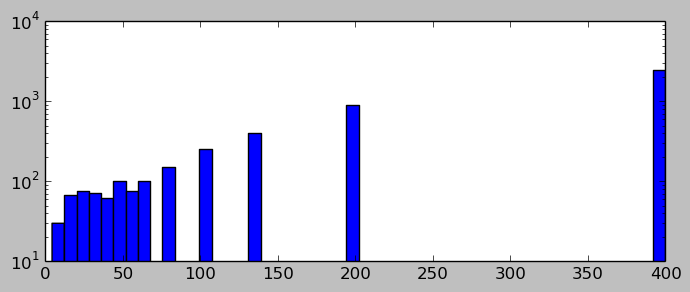

In [23]:
import matplotlib.pyplot as plt

small_idf_values = idfsSmall.map(lambda s: s[1]).collect()
fig = plt.figure(figsize=(8,3))
plt.hist(small_idf_values, 50, log=True)
pass

### **(2f) Implementar la función TF-IDF**
#### Utiliza la función `tf` para implementar una función `tfidf(tokens, idfs)` que tome un lista de tokens de un documento un dicionario de Python de pesos IDF y devuelva un dicionario de Python que mapee los tokens individuales a pesos TF-IDF.
#### Los pasos que la funcion debe realizar son:
* #### Calcular la frecuencia de los tokens para el parámetro `tokens`
* #### Crear un dicionario Python donde cada token se mapee a su frecuencia de token por su peso IDF.
#### Utilizar la función `tfidf` para calcular los pesos del producto de Amazon 'b000hkgj8k'. Para ello necesitamos extraer ese registro del dataset pequeño de Amazon tokenizado y convertir los IDFs del dataset pequeño de Amazon en un diccionario Python. Para la primer parte podemos usar una transformación `filter()` para extraer el registro y una acción `collect()`para devolver el valor al driver. Para la segunda parte usaremos la acción [`collectAsMap()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap) para devolver los IDFs al driver como un diccionario Python.

In [24]:
# TODO: Sustituye <RELLENA> con el código apropiado
def tfidf(tokens, idfs):
    """ Calcula TF-IDF
    Args:
        tokens (list of str): lista de tokens de tokenize
        idfs (dictionary): diccionario con los valores IDF
    Returns:
        dictionary: un diccionario de registros con valores TF-IDF
    """
    tfs = tf (tokens) #diccionario {tk1:0.25, tk2:0.75, ...}
    tfIdfDict = {}
    for key, value in tfs.iteritems():
        tfIdfDict [key] = value * idfs[key]
    return tfIdfDict # diccionario {tk1:valr tf-idf, tk2: tf-idf,....}

#amazonRecToToken RDD[(id,[tok1, tok2, ...])]
recb000hkgj8k = amazonRecToToken.filter(lambda x: x[0] == 'b000hkgj8k').collect()[0][1] #lista de tokens
#idfsSmall = idfs(amazonRecToToken.union(googleRecToToken)) #RDD [(token, valorIDF)] de union de amazon y google

idfsSmallWeights = idfsSmall.collectAsMap() # ojo lo podemos hacer pq la unión de los dataset es pequeña
#idfsSmallWeight es un diccionario python {tk1: valorIDF, tk2: valorIDF, .....}
rec_b000hkgj8k_weights = tfidf(recb000hkgj8k, idfsSmallWeights) # diccionario {tk1: valor tf-idf1, tk2: valor tf-idf2, ...}

print 'El registro Amazon "b000hkgj8k" tiene los siguientes tokens y pesos:\n%s' % rec_b000hkgj8k_weights

El registro Amazon "b000hkgj8k" tiene los siguientes tokens y pesos:
{'autocad': 33.33333333333333, 'autodesk': 8.333333333333332, 'courseware': 66.66666666666666, 'psg': 33.33333333333333, '2007': 3.5087719298245617, 'customizing': 16.666666666666664, 'interface': 3.0303030303030303}


In [25]:
# TEST Implementar la función TF-IDF (2f)
Test.assertEquals(rec_b000hkgj8k_weights,
                   {'autocad': 33.33333333333333, 'autodesk': 8.333333333333332,
                    'courseware': 66.66666666666666, 'psg': 33.33333333333333,
                    '2007': 3.5087719298245617, 'customizing': 16.666666666666664,
                    'interface': 3.0303030303030303}, 'rec_b000hkgj8k_weights incorrectos')

1 test passed.


### **Parte 3: ER como Similutud de Texto - Similitud del Coseno (Cosine Similarity)**
#### Ahora estamos listos para hacer comparaciones de texto de una manera formal. Usaremos la métrica **[cosine similarity][cosine]** para medir la distancia entre strings. Trataremos cada documento como un vector en un espacio n-dimensional y compararemos los dos documentos calculando el coseno del ángulo entre los dos vectores. Es *más* fácil de lo que parece.

#### La primera cuestión a resolver es como representar los documentos como vectores. la Respuesta es fácil: ¡Bag-of-words! Trataremos cada token único como una dimensión y los pesos como magnitudes en cada una de las dimensiones. Por ejemplo, supongamos que utilizamos la cuenta simple como pesos y queremos interpretar la cadena "Hello, world! Goodbay, world!" como un vector. "Hello" y "goodbay" son dimensiones del vector con valor 1 y la dimensión "world" tiene valor 2 y el resto de las otras dimensiones serán cero.
#### La siguiente cuestion es: Dados dos vectores como calcularemos el coseno del ángulo entre ellos. Para eso utilizarmos la fórmula del producto escalar entre dos vectores (dot product):
#### $$ a \cdot b = \| a \| \| b \| \cos \theta $$
#### Donde $ a \cdot b = \sum a_i b_i $ es el producto escalar de dos vectores, y$ \|a\| = \sqrt{ \sum a_i^2 } $ es la [norma vectorial](https://es.wikipedia.org/wiki/Norma_vectorial) de $ a $.
#### Podemos reorganizar los términos para despejar el coseno y comprobar que es el producto normalizado de dos vectores. Para nuestro modelo de vector, el cálculo del producto escalar y de las normas son funciones simples de la representación de un documento como una bag-of-words. Así pues estamos en codiciones de calcular la similitud:
#### $$ similarity = \cos \theta = \frac{a \cdot b}{\|a\| \|b\|} = \frac{\sum a_i b_i}{\sqrt{\sum a_i^2} \sqrt{\sum b_i^2}} $$
#### Dejando a un lado el álgebra, la interpretación geométrica es más intituitiva. El ángulo entre dos vectores de documentos es pequeña si tienen muchos tokens en común porque están apuntando más o menos en la misma direccion con lo que el conseno del ángulo que formen será grande, por otro lado si el ángulo es grande (tienen pocas palabras en común) su coseno será pequeño.
[cosine]: https://en.wikipedia.org/wiki/Cosine_similarity

### **(3a) Implementar los componentes de la función `cosineSimilarity`**
#### Implement the components of a `cosineSimilarity` function.
#### Usa las funciones `tokenize` y `tfidf` y los pesos IDF de la parte 2 para extraer tokens y asignarles pesos

#### Los pasos son los siguientes:
* #### Definir una función `dotprod` que tome dos diccionarios de Python y devuelva el producto escalar (dot product) entre ellos donde dot product se define como la suma de los productos de los valores para los tokens que aparezcan en *ambos* diccionarios
* #### Definir una función `norm` que devuelva la raíz cuadrada del dot product de un diccionario consigo misma
* #### Definir una función `cossim` que devuelva el dot product de dos diccionario dividido por la norma del primer diccionario y multiplicado por la norma del segundo diccionario

In [26]:
# TODO: Sustituye <RELLENA> con el código apropiado
import math

def dotprod(a, b):
    """ Calcula dot product
    Args:
        a (dictionary): primer diccionario de registro a valor
        b (dictionary): segundo diccionario de registro a valor
    Returns:
        dotProd: Resultado del dot producto con los dos diccionarios de entrada
    """
    productoEscalar = 0.0
    for key in a:
        if key in b:
            productoEscalar = productoEscalar + (a[key] * b[key])
    return productoEscalar

def norm(a):
    """ Calcula la raíz cuadrada del dot product
    Args:
        a (dictionary): un diccionario de registro a valor
    Returns:
        norm: la norma euclídea
    """
    sumCuad = 0.0
    for key in a:
        sumCuad = sumCuad + (a[key] ** 2)
        
    return math.sqrt (sumCuad)

def cossim(a, b):
    """ Calcula la cosine similarity
    Args:
        a (dictionary): primer diccionario de registro a valor
        b (dictionary): segundo diccionario de registro a valor
    Returns:
        cossim: dot product de dos diccionarios divido por la norma del primer diccionario multiplicado por la
        norma del segundo
    """
    return dotprod (a,b) / (norm(a) * norm(b))

testVec1 = {'foo': 2, 'bar': 3, 'baz': 5 }
testVec2 = {'foo': 1, 'bar': 0, 'baz': 20 }
dp = dotprod(testVec1, testVec2)
nm = norm(testVec1)
print dp, nm

102.0 6.16441400297


In [27]:
# TEST Implementar los componentes de la función cosineSimilarity (3a)
Test.assertEquals(dp, 102, 'dp incorrecto')
Test.assertTrue(abs(nm - 6.16441400297) < 0.0000001, 'nm incorrrecto')

1 test passed.
1 test passed.


### **(3b) Implementar la función `cosineSimilarity`**
#### Implementar la función `cosineSimilarity(string1, string2, idfsDictionary)` que toma dos strings y un diccionario de pesos IDF y calcula su cosine similarity.
#### Los pasos a realizar son:
* #### Aplicar la función `tfidf` a las strings 1 y 2 tokenizadas usando el diccionario de pesos IDF
* #### Calcular y devolver la función `cossim` aplicada a los resultados de las dos funciones `tfidf`

In [30]:
# TODO: Sustituye <RELLENA> con el código apropiado
def cosineSimilarity(string1, string2, idfsDictionary):
    """ Calcula la cosine similarity entre dos strings
    Args:
        string1 (str): primera string
        string2 (str): segunda string
        idfsDictionary (dictionary):un diccionario de valores IDF
    Returns:
        cossim: valor cosine similarity 
    """
    #tfidf devuelve un diccionario de registros con valores TF-IDF
    w1 = tfidf(tokenize(string1),idfsDictionary)
    w2 = tfidf(tokenize(string2),idfsDictionary)
    return cossim(w1, w2)

cossimAdobe = cosineSimilarity('Adobe Photoshop',
                               'Adobe Illustrator',
                               idfsSmallWeights)

print cossimAdobe

0.0577243382163


In [31]:
# TEST Implementar la función cosineSimilarity (3b)
Test.assertTrue(abs(cossimAdobe - 0.0577243382163) < 0.0000001, 'cossimAdobe incorrecto')

1 test passed.


### **(3c) Realizar la resolución de entidades**
#### Por último ¡Ya podemos realizar la resolución de entidades!
#### Para *cada* registro de producto en el dataset pequeño de Google usaremos la función `cosineSimilarity` para calcular su similitud con cada registro de el dataset pequeño de Amazon, entonces construiremos un diccionario de mapeo de tuplas `(Google URL, Amazon ID)` con valores de similitud entre 0 y 1.
#### Haremos este cálculo de dos maneras diferentes primero sin variables de broadcast y despúes usándolas.
#### Los pasos a realizar son:
* #### Crear un RDD combinación del dataset pequeño de Google y el de Amazon que tenga como elementos todos los pares de elementos con la forma: `[ ((Google URL1, Google String1), (Amazon ID1, Amazon String1)), ((Google URL1, Google String1), (Amazon ID2, Amazon String2)), ((Google URL2, Google String2), (Amazon ID1, Amazon String1)), ... ]`
* #### Definir una función worker que dado un elemento del RDD anterior calcule cosineSimlarity para los dos registros en el elemento
* #### Aplicar la función a cada elemento del RDD
####  Calcula la similitud entre el registro de Amazon `b000o24l3q` y el registro de Google  `http://www.google.com/base/feeds/snippets/17242822440574356561`. 

In [33]:
crossSmall = (googleSmall
              .cartesian (amazonSmall)
              .cache())

def computeSimilarity(record):
    """ Compute similarity on a combination record
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallWeights)
    return (googleURL, amazonID, cs)


similarities = (crossSmall
                .map (lambda record: computeSimilarity(record))
                .cache())
#similarities -> RDD [(googleURL, amazonID, cs)]

def similar(amazonID, googleURL):
    """ Return similarity value
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similarities
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogle = similar('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print 'Requested similarity is %s.' % similarityAmazonGoogle


Requested similarity is 0.000303171940451.


In [34]:
# TEST Realizar la ER (3c)
Test.assertTrue(abs(similarityAmazonGoogle - 0.000303171940451) < 0.0000001,
                'similarityAmazonGoogle incorrecta')

1 test passed.


### **(3d) Realizar la ER con variables de Broadcast**
#### La solución de (3c) funciona bien para datasets pequeños pero requiere que Spark (automáticamente) mande la variable `idfsSmallWeights` a todos los workers. Si no hiciesemos  `cache()` en similarities,  se tendría que recrear cada ver que se llamase a  a `similar()` lo que haría que  `idfsSmallWeights` se enviase cada vez.
#### Es mejor utilizar una variable de broadcast, definimos esta variable en el driver y nos podemos referir a ella en cada worker. Spark guarda la variable en cada uno de ellos y sólo la tenemos que enviar una vez.
#### Pasos a realizar:
* #### Definir una función `computeSimilarityBroadcast` que dado un elemento del RDD combinado calcule la similitud del coseno para dos los dos registros de cada elemento. Será la misma función `computeSimilarity` de (3c) excepto que utiliza una función de broadcast.
* #### Aplicar la función worker a cada elemento del RDD
#### Calcula de nuevo la similitud entre el registro Amazon `b000o24l3q` y el registro Google `http://www.google.com/base/feeds/snippets/17242822440574356561`.

In [35]:
# TODO: Sustituye <RELLENA> con el código apropiado
def computeSimilarityBroadcast(record):
    """ Calcula la similitud en un registro combinado utilizando una variable de Broadcast
    Args:
        record: un par (google record, amazon record)
    Returns:
        tupla: una tupla (google URL, amazon ID, valor cosine similarity)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallBroadcast.value)
    return (googleURL, amazonID, cs)

idfsSmallBroadcast = sc.broadcast(idfsSmallWeights)
similaritiesBroadcast = (crossSmall
                         .map (lambda record: computeSimilarityBroadcast (record))
                         .cache())


def similarBroadcast(amazonID, googleURL):
    """ Devuelve un valor de similitud calculado utilizando una variable de broadcast
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: valor de cosine similarity
    """
    return (similaritiesBroadcast
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogleBroadcast = similarBroadcast('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print 'La similitud es %s.' % similarityAmazonGoogleBroadcast

La similitud es 0.000303171940451.


In [36]:
# TEST Realiza ER con variables de Broadcast (3d)
from pyspark import Broadcast
Test.assertTrue(isinstance(idfsSmallBroadcast, Broadcast), 'idfsSmallBroadcast incorrecto')
Test.assertEquals(len(idfsSmallBroadcast.value), 4772, 'valor idfsSmallBroadcast incorrecto')
Test.assertTrue(abs(similarityAmazonGoogleBroadcast - 0.000303171940451) < 0.0000001,
                'similarityAmazonGoogle incorrecta')

1 test passed.
1 test passed.
1 test passed.


### **(3e) Realizar la evaluación Gold Standard**
#### Primero cargaremos los datos "gold standard" y los utilizaremos para resolver algunas cuestiones. Leeremos y parsearemos las líneas de los datos Gold Standard que tienen el siguiente formato: "Amazon Product ID","Google URL". El RDD resultado tendrá elementos de la forma ("AmazonID GoogleURL", 'gold', 1 ó 0)

In [46]:
GOLDFILE_PATTERN = '^(.+),(.+)'
# Parse each line of a data file useing the specified regular expression pattern
def parse_goldfile_line(goldfile_line):
    """ Parsea una linea de fichero de datos 'golden standard'
    Args:
        goldfile_line: una línea de datos
    Returns:
        tupla: ((key, 'gold', 1 en caso de éxito,  0 si no))
    """
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print 'linea de goldfile invalida: %s' % goldfile_line
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print 'linea de cabecera: %s' % goldfile_line
        return (goldfile_line, 0)
    else:
        key = '%s %s' % (removeQuotes(match.group(1)), removeQuotes(match.group(2)))
        return ((key, 'gold'), 1)

goldfile = os.path.join(baseDir, inputPath, GOLD_STANDARD_PATH)
gsRaw = (sc
         .textFile(goldfile)
         .map(parse_goldfile_line)
         .cache())

gsFailed = (gsRaw
            .filter(lambda s: s[1] == -1)
            .map(lambda s: s[0]))
for line in gsFailed.take(10):
    print 'linea de goldfile invalida: %s' % line

goldStandard = (gsRaw
                .filter(lambda s: s[1] == 1)
                .map(lambda s: s[0])
                .cache())

print 'Leidas %d líneas, parseadas con éxito %d lineas, falladas al parsear %d lineas' % (gsRaw.count(), goldStandard.count(), gsFailed.count())

assert (gsFailed.count() == 0)
assert (gsRaw.count() == (goldStandard.count() + 1))

Leidas 1301 líneas, parseadas con éxito 1300 líneas, falladas al parsear 0 líneas


### Usando los datos "gold standard" podemos responder a las siguientes preguntas:
* #### ¿Cuántos duplicados reales hay en los datasets pequeños?
* #### ¿Cúal es la media de similitud para los duplicados reales?
* #### ¿Y de los no duplicados?
#### Los pasos a realizar son:
* #### Crea un nuevo `sims` RDD a partir de `similaritiesBroadcast` RDD, donde cada elemento sea un par de la forma ("AmazonID GoogleURL", cosineSimilarityScore). Un ejemplo de `sims` podría ser: ('b000bi7uqs http://www.google.com/base/feeds/snippets/18403148885652932189', 0.40202896125621296)
* #### Haz la composición de  `sims` RDD con el `goldStandard` RDD para crear un nuevo `trueDupsRDD` RDD que tiene el valor de similitud del coseno para los pares "AmazonID GoogleURL" que aparezcan tanto en `sims` RDD como en `goldStandard` RDD. Pista: Puedes usar la transformación join().

* #### Cuenta el número de pares duplicado reales en `trueDupsRDD` dataset
* #### Calcula la media de similitud para los duplicados reales en `trueDupsRDD` dataset. Utiliza `float` en los cálculos
* #### Crea un nuevo RDD `nonDupsRDD` que tenga los valores de similitud del coseno para los pares "AmazonID GoogleURL"  del RDD `similaritiesBroadcast` que  **NO** aparezcan ni en *sims* RDD ni en el gold Standard RDD.
* #### Calcula la similitud media para los no duplicados en el último dataset. Recuerda usar `float` en los cálculos

In [48]:
# TODO: Sustituye <RELLENA> con el código apropiado
sims = similaritiesBroadcast.map (lambda (googleURL, amazonId, cs): (amazonId + " " + googleURL , cs))

trueDupsRDD = (sims
               .join (goldStandard))
trueDupsCount = trueDupsRDD.count ()
avgSimDups = float (trueDupsRDD.values().map (lambda (cs, gold): cs).sum()) / trueDupsCount

toSubtract = trueDupsRDD.map (lambda (amazon_google, (cs, gold)): (amazon_google, cs))
nonDupsRDD = sims.subtract (toSubtract)
avgSimNon =  float (nonDupsRDD.values().sum()) / nonDupsRDD.count()

print 'Hay %s duplicados reales.' % trueDupsCount
print 'La media de los duplicados reales es %s.' % avgSimDups
print 'y para los no duplicados la media es %s.' % avgSimNon

Hay 146 duplicados reales.
La media de los duplicados reales es 0.264332573435.
y para los no duplicados la media es 0.00123476304656.


In [ ]:
# TEST Realizar una evaluación Gold Standard (3e)
Test.assertEquals(trueDupsCount, 146, 'trueDupsCount incorrecta')
Test.assertTrue(abs(avgSimDups - 0.264332573435) < 0.0000001, 'avgSimDups incorrecta')
Test.assertTrue(abs(avgSimNon - 0.00123476304656) < 0.0000001, 'avgSimNon incorrecta')

### **Parte 4: ER escalable**
#### La función de similitud construida anteriormente sólo la podemos utilizar para pequeños datasets ya que su complejidad es cuadrática y no es práctica incluso para datasets de tamaño mediano. En esta parte implementaremos un algoritmo más escalable y lo usaremos para la resolución de entidades en todo el dataset.
### Índices invertidos
#### Para mejorar el algoritmo ER empezaremos analizando su tiempo de ejecución. El algoritmo es cuadrático de dos maneras, por un lado hace un montón de cálculos redundantes de los tokens y los pesos ya que cada registro se reprocesa cada vez que se compara. Por otro lado se hacen de manera cuadrática las comparaciones de tokens entre registros.
#### El primer problema se puede eliminar realizando un precálculo y almacenando los resultados en tablas de look-up, El segundo problema es un poco más dificil. En el peor de los casos, cada token en cada registro en un dataset existe en cada registro del otro dataset por lo que cada token hará una contribución distinta de cero a la similitud del coseno. En ese caso la comparación de tokens es inevitablemente cuadrática.
#### Pero en realidad la mayoría de los registros no tiene nada (o muy poco) en común, por otra parte lo normal será que un registro en un dataset tenga como mucho un duplicado en el otro (asumiendo que cada dataset ha sido deduplicado contra si mismo previamente) en este caso la salida será lineal con respecto al tamaño de la entrada y podemos esperar a alcanzar un tiempo de ejecución lineal.
#### Un [**Índice invertido**](https://en.wikipedia.org/wiki/Inverted_index) es una estructura de datos que nos permitirá evitar hacer comparaciones cuadráticas de datos. Mapea cada token en el dataset con la lista de documentos que contiene ese token así en vez de comparar registro a registro cada token con otro para ver se hay coincidencia usaremos índices invertidos para hacer un *look up* de los registros para un token particular.
> #### **Nota sobre la terminología**: En búsqueda de textos un índice *directo* (*foward*) mapea los documentos en un dataset con los tokens que contienen. Un índice *invertido* (*inverted*) realiza el mapeo inverso.
> #### **Nota**: Para esta sección usaremos los datasets completos de Google y Amazon no las muestras.

### **(4a) Tokenizar el dataset completo**
#### Tokenizar cada uno de los dos dataset completos para Google y Amazon.

In [51]:
# TODO: Sustituye <RELLENA> con el código apropiado
# RDDs  [(ids,[tok1, tok2, ...])
amazonFullRecToToken = amazon.mapValues (lambda string: tokenize(string))
googleFullRecToToken = google.mapValues (lambda string: tokenize(string))
print 'El dataset completo de Amazon tiene %s productos, El dataset completo de Google tiene %s productos' %  (amazonFullRecToToken.count(), googleFullRecToToken.count())

El dataset completo de Amazon tiene 1363 productos, El dataset completo de Google tiene 3226 productos


In [ ]:
# TEST tokenizar el dataset completo (4a)
Test.assertEquals(amazonFullRecToToken.count(), 1363, 'amazonFullRecToToken.count() incorrecta')
Test.assertEquals(googleFullRecToToken.count(), 3226, 'googleFullRecToToken.count() incorrecta')

### **(4b) Calcular IDFs y TF-IDFs para los dataset completos**
#### Reusaremos el código anterior para calcular los pesos IDF para todo el dataset combinado
#### Pasos a realizar:
* #### Crear un nuevo `fullCorpusRDD` que contenga los tokens de los datasets completos de Amazon y Google.
* #### Aplicar la función `idfs` a `fullCorpusRDD`
* #### Crear una variable de broadcast que contenga un diccionario de los pesos IDF para todo el dataset. 
* #### Para cada dataset completo de Amazon y Google crear RDDs de pesos que mapeen IDs/URLs a vectores de tokens TF-IDF ponderados.

In [52]:
# TODO: Sustituye <RELLENA> con el código apropiado
#RDD[(ids,[tok1, tok2, ...]) con amazon y google
fullCorpusRDD = amazonFullRecToToken.union (googleFullRecToToken)
idfsFull = idfs(fullCorpusRDD)
idfsFullCount = idfsFull.count()
print 'Hay %s tokens únicos en los dataset completos.' % idfsFullCount

# Recalcular IDFs para todo el dataset
idfsFullWeights = idfsFull.collectAsMap() #ahora el diccionario es mucho mayor pero asumimos que cabe en cada nodo del cluster
idfsFullBroadcast = sc.broadcast (idfsFullWeights)

# Precalcular los pesos TF-IDF. Construir el mapeo entre el ID del registro al vector de pesos
# RDD [(idAmazon/urlgoogle, {tok-a: 0.20, tok-c: 0.50, ... })]
amazonWeightsRDD = amazonFullRecToToken.mapValues (lambda tokens: tfidf (tokens, idfsFullBroadcast.value))
googleWeightsRDD = googleFullRecToToken.mapValues (lambda tokens: tfidf (tokens, idfsFullBroadcast.value))

print 'Hay %s pesos de Amazon y %s pesos de Google.' % (amazonWeightsRDD.count(),
                                                              googleWeightsRDD.count())

Hay 17078 tokens únicos en los dataset completos.
Hay 1363 pesos de Amazon y 3226 pesos de Google.


In [54]:
# TEST Calcular IDFs y TF-IDFs para todo el dataset (4b)
Test.assertEquals(idfsFullCount, 17078, 'idfsFullCount incorrecta')
Test.assertEquals(amazonWeightsRDD.count(), 1363,  'amazonWeightsRDD.count() incorrecta')
Test.assertEquals(googleWeightsRDD.count(), 3226, 'googleWeightsRDD.count() incorrecta')

1 test passed.
1 test passed.
1 test passed.


### **(4c) Calcular las normas para los pesos de todo el dataset**
#### Reutilizaremos el código anterior para calcular las normas de los pesos IDF para todo el dataset combinado.
#### Los pasos a realizar son:
* #### Crear dos colecciones, una por cada uno de los datasets completos de Amazon y Google, donde los IDS/URLs mapean la norma de sus vectores de pesos de tokens TF-IDF.
* #### Convertir cada colección en una variable de broadcast que contenga un dicionario de la norma de los pesos IDF para todo el dataset.

In [55]:
# TODO: Sustituye <RELLENA> con el código apropiado

#RDD [(idAmazon/urlgoogle, {tok-a: 0.20, tok-c: 0.50, ... })] --> RDDs[(idAmazon/urlgoogle, norma)] --> diccionario Python {id1:norma2, id2: norma2...}
amazonNorms = amazonWeightsRDD.mapValues (lambda dict: norm(dict)).collectAsMap()
amazonNormsBroadcast = sc.broadcast (amazonNorms)
googleNorms = googleWeightsRDD.mapValues (lambda dict: norm(dict)).collectAsMap()
googleNormsBroadcast = sc.broadcast (googleNorms)


In [56]:
# TEST Calcula las Normas para los pesos de todo el dataset (4c)
Test.assertTrue(isinstance(amazonNormsBroadcast, Broadcast), 'amazonNormsBroadcast incorrecta')
Test.assertEquals(len(amazonNormsBroadcast.value), 1363, 'amazonNormsBroadcast.value incorrecto')
Test.assertTrue(isinstance(googleNormsBroadcast, Broadcast), 'googleNormsBroadcast incorrecta')
Test.assertEquals(len(googleNormsBroadcast.value), 3226, 'googleNormsBroadcast.value incorrecto')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### **(4d) Crear índices invertidos para ambas fuentes de datos**
#### Los pasos a realizar son:
* #### Crear una función de inversión que dado un par (ID/URL, vector de pesos de tokens TF-IDF) devuelva una lista de pares (token, ID/URL). Hay que recordar que el vector de pesos de tokens TF-IDF es un diccionario Python con keys que son los tokens y valores que son los pesos.
* #### Usar la función de inversión para convertir los dataset de Amazon y Google de vectores de pesos de tokens TF-IDF en dos RDDs donde cada elemento es un par de un token y un ID/URL que contiene ese token. Estos son los índices invertidos.

In [57]:
# TODO: Sustituye <RELLENA> con el código apropiado
#record -> (idAmazon/urlgoogle, {tok-a: 0.20, tok-c: 0.50, ... })
def invert(record):
    """ Invierte (ID, tokens) en una lista de (token, ID)
    Args:
        record: un park, (ID, token vector)
    Returns:
        pairs: una lista de pares de token a ID
    """
    tokenDict = record[1]
    pairs = []
    for key in tokenDict:
        pairs.append ((key,record[0]))
    
    return (pairs) #devuelve lista de [(token,Id-amazon/google ), (token, Id-amazon/google), ....]

#amazonWeightsRDD -> RDD [(idAmazon/urlgoogle, {tok-a: 0.20, tok-c: 0.50, ... })]

amazonInvPairsRDD = (amazonWeightsRDD
                    .flatMap (lambda record: invert (record))
                    .cache())

googleInvPairsRDD = (googleWeightsRDD
                    .flatMap (lambda record: invert (record))
                    .cache())
#amazonInvPairsRDD o googleInvPairsRDD --> RDDs[(token,id-amazon/google)]

print 'Hay %s pares invertidos de Amazon y %s pares invertidos de Google.' % (amazonInvPairsRDD.count(),
                                                                            googleInvPairsRDD.count())

Hay 111387 pares invertidos de Amazon y 77678 pares invertidos de Google.


In [58]:
# TEST Crear índices invertidos para todo el dataset (4d)
invertedPair = invert((1, {'foo': 2}))
Test.assertEquals(invertedPair[0][1], 1, 'resultado de inversión incorrecto')
Test.assertEquals(amazonInvPairsRDD.count(), 111387, 'amazonInvPairsRDD.count() incorrecta')
Test.assertEquals(googleInvPairsRDD.count(), 77678, 'googleInvPairsRDD.count() incorrecta')

1 test passed.
1 test passed.
1 test passed.


### **(4e) Identificar tokens comunes en todo el dataset**
#### Ahora podemos realizar de manera eficiente la ER en todo el dataset. Implementando el siguiente algoritmo para construir un RDD que mapee un par (ID, URL) a  una lista de tokens que tienen en común: 
* #### Usando los dos índices invertidos (RDDs donde cada elemento es un par de un token y el ID o URL que contiene ese token), crea un nuevo RDD que contenga sólo los tokens que aparezcan ambos datasets, los elementos de este RDD serán de la forma (token, iterable (ID, URL)).

* #### Necesitamos un mapeo de (ID, URL) a token asi que crearemos una función que haga el swap de los elementos del RDD anterior para tener un nuevo RDD de la forma ((ID, URL), token).
* #### Por último crear un RDD que contenga pares (ID, URL)  con todos los tokens que estos pares tengan en común.

In [59]:
# TODO: Sustituye <RELLENA> con el código apropiado
def swap(record):
    """ Swap (token, (ID, URL)) a ((ID, URL), token)
    Args:
        record: un par, (token, (ID, URL))
    Returns:
        pair: ((ID, URL), token)
    """
    token = record[0]
    keys = record[1]
    return (keys, token)

commonTokens = (amazonInvPairsRDD # RDDs[(token,id-amazon/google)] -> RDD[(token, (id-amazon,url-google)) ]-> RDD[((id-amazon,url-google), token)]
                .join (googleInvPairsRDD).map (lambda record: swap (record)).groupByKey()
                .cache())

## RDDs[(token,id-amazon/google)] -> RDD[(token, (id-amazon,url-google)) ]-> RDD[((id-amazon,url-google), token)]
# groupbykey -> RDD [((id-amazon,url-google),[token1, token2, token3...])]

print 'Encontrados %d tokens en común' % commonTokens.count()

Encontrados 2441100 tokens en común


In [60]:
# TEST Identificar los tokens en comun en el dataset (4e)
Test.assertEquals(commonTokens.count(), 2441100, 'incorrect commonTokens.count()')

1 test passed.


### **(4f) Identificar tokens comunes en todo el dataset cont.**
#### Utiliza las estructuras de datos de la parte **(4a)** y **(4e)** para construir un diccionario que mapee pares de registros a valores de similitud del coseno.  
#### Los pasos a realizar son:
* #### Crear dos diccionarios de broadcast para los RDDs amazonWeights y googleWeights
* #### Crear una función `fastCosinesSimilarity` que tome un registros del tipo ((Amazon ID, Google URL), lista de tokens) y calcule la suma para cada uno de los tokens en la lista de tokens como resultado de multiplicar el peso del token de amazon por el peso del token Google. La suma se dividirá entre la norma de la URL de Google y luego entre la norma del ID de Amazon. La función debe devolver el valor como un par en la que la clave sea (Amazon ID, Google URL). *Asegúrate de usar las variables de broadcast creadas para pesos y normas*

* #### Aplica la función `fastCosinesSimilarity` a los tokens de todo el dataset

In [ ]:
# TODO: Sustituye <RELLENA> con el código apropiado
amazonWeightsBroadcast = sc.broadcast (amazonWeightsRDD.collectAsMap())
googleWeightsBroadcast = sc.broadcast (googleWeightsRDD.collectAsMap())


def fastCosineSimilarity(record):
    amazonRec = record[0][0]
    googleRec = record[0][1]
    tokens = record[1]
    
    s = 0.0
    for key in tokens:
        dictAmazon = amazonWeightsBroadcast.value
        dictAmazonTokens = dictAmazon[amazonRec]
        amazonWeight = 0.0
        if key in dictAmazonTokens:
            amazonWeight = dictAmazonTokens[key]
        
        dictGoogle = googleWeightsBroadcast.value
        dictGoogleTokens = dictGoogle[googleRec]
        googleWeight = 0.0
        if key in dictGoogleTokens:
            googleWeight = dictGoogleTokens[key]
    
        s = s + (amazonWeight * googleWeight)
    
    value = float (s) / (amazonNorms[amazonRec] * googleNorms[googleRec])
    key = (amazonRec, googleRec)
    return (key, value)

similaritiesFullRDD = (commonTokens
                       .map (lambda record: fastCosineSimilarity (record))
                       .cache())

print similaritiesFullRDD.count()

In [ ]:
# TEST Identificar tokens comunes en todo el dataset cont. (4f)
similarityTest = similaritiesFullRDD.filter(lambda ((aID, gURL), cs): aID == 'b00005lzly' and gURL == 'http://www.google.com/base/feeds/snippets/13823221823254120257').collect()
Test.assertEquals(len(similarityTest), 1, 'len(similarityTest) incorrecta')
Test.assertTrue(abs(similarityTest[0][1] - 4.286548414e-06) < 0.000000000001, 'similarityTest fastCosineSimilarity incorrecto')
Test.assertEquals(similaritiesFullRDD.count(), 2441100, 'similaritiesFullRDD.count() incorrecto')

### **Parte 5: Análisis**
#### Ahora tenemos una lista fiable de pares de registros con su similitudes pero necesitamos una manera de decidir si dos registros son duplicados o no. La forma más simple es elegir un **threshold**. Los pares cuya similitud esté por encima de ese threshold son considerados duplicados y los que estén por debajo serán considerados distintos.

#### Para decidir donde situar el thresold necesitamos entender que clase de errores resultarán a diferentes niveles. Si seleccionamos un threshold muy bajo obtendremos **falsos positivos** esto es pares de registros que consideraremos duplicados cuando realmente no lo son. Si lo ponemos demasiado alto obtendremos **falsos negativos** esto es pares de registros que realmente son duplicados pero que perderemos.

#### Los algoritmos ER se evaluan con métricas de la [teoría de la búsqueda y recuperación de información](https://es.wikipedia.org/wiki/B%C3%BAsqueda_y_recuperaci%C3%B3n_de_informaci%C3%B3n) llamadas **precisión (precission)** y **Exhaustividad (recall)**. La precisión pregunta de todos los pares de registros marcados como duplicados la fracción de los que realmente son duplicados. Recall pregunta de entre todos los verdaderos duplicados en los datos la fracción que realmente se encontró con éxito. Como con los falsos positivos y falsos negativos hay una compensación entre entre precisión y racall. Una tercera métrica **medida F (F-measure)** toma la [media armónica](https://es.wikipedia.org/wiki/Media_arm%C3%B3nica) de precisión y recall para medir la bondad total en un único valor:
#### $$ Fmeasure = 2 \frac{precision * recall}{precision + recall} $$
> #### **Nota**: En esta parte usaremos el fichero "gold standard" para comprobar los verdaderos duplicados y los resultados de la parte 4.
> #### **Nota**: ¡Eh! Ya no vas a escribir más código. Ejecuta cada celda y quedate con la idea general

### **(5a) Contando Verdaderos Positivos, Falsos Positivos y Falsos Negativos**
#### Necesitamos funciones que cuenten verdaderos positivos (verdaderos duplicados por encima del threshold), falsos positivos y falsos negativos: 
* #### Creamos `simsFullRDD` desde `similaritiesFullRDD` que tendrá elementos de la forma ((Amazon ID, Google URL), similarity score)
* #### A partir de este RDD, creamos otro sólo con los similarity scores
* #### Para buscar verdaderos duplicados hacemos un left outer join con el `goldStandard` RDD y `simsFullRDD` 

In [ ]:
# Crear RDD de ((Amazon ID, Google URL), similarity score)
simsFullRDD = similaritiesFullRDD.map(lambda x: ("%s %s" % (x[0][0], x[0][1]), x[1]))
assert (simsFullRDD.count() == 2441100)

# Crear RDD sólo con similarity scores
simsFullValuesRDD = (simsFullRDD
                     .map(lambda x: x[1])
                     .cache())
assert (simsFullValuesRDD.count() == 2441100)

# Buscamos todos los similarity scores para verdaderos positivos

# Esta función devolverá el score de similitud para registros que estan en el gol standard y en simsFulRDD 
#(Verdaderos positivos) y devolverá 0 para registros que están en el gold standar pero no estan en 
#simsFullRDD (Falsos Negativos)
def gs_value(record):
    if (record[1][1] is None):
        return 0
    else:
        return record[1][1]

# Join del gold standard y simsFullRDD y luego extrae los similarities scores utilizado la función anterior 
trueDupSimsRDD = (goldStandard
                  .leftOuterJoin(simsFullRDD)
                  .map(gs_value)
                  .cache())
print 'Hay %s duplicados verdaderos.' % trueDupSimsRDD.count()
assert(trueDupSimsRDD.count() == 1300)

#### El siguiente paso es elegir un threshold entre 0 y 1 para contar los Verdaderos Positivos (verdaderos duplicados por encima del threshold). Queremos explorar varios thresholds diferentes. Para hacer esto dividimos el espacio de thresholds en 100 contenedores y hacemos lo siguiente:

* #### Utilizamos acumuladores de Spark para implementar nuestra función de conteo. Definimos un tipo de acumulador `VectorAccumulatorParam`, junto con funciones para inicializar el vector del acumulador a cero y sumar dos vectores. Usamos el operador += porque solo se puede sumar en un acumulador.
* #### Creamos una función auxiliar para tener una lista con una entrada (bit) puesto a un valor y los otros a 0.
* #### Creamos 101 contenedores para los 100 valores de threshold entre 0 y 1.
* #### Ahora por cada similarity score, calculamos los falsos positivos. Hacemos esto sumando cada similarity score al contenedor apropiado del vector. Luego borramos los verdaderos positivos del vector usando los datos de gold standard
* #### Definimos funciones para calcular falsos positivos y negativos y verdaderos positivos para un threshold dado 

In [ ]:
#https://spark.apache.org/docs/1.1.0/api/python/pyspark.accumulators-module.html
from pyspark.accumulators import AccumulatorParam
class VectorAccumulatorParam(AccumulatorParam):
    # Inicializar el vector de acumulacion a 0
    def zero(self, value):
        return [0] * len(value)

    # suma dos variables del vector de acumulacion
    def addInPlace(self, val1, val2):
        for i in xrange(len(val1)):
            val1[i] += val2[i]
        return val1

# devuelve una lista con la entrada x puesta a un valor y el resto de las entradas a 0
def set_bit(x, value, length):
    bits = []
    for y in xrange(length):
        if (x == y):
          bits.append(value)
        else:
          bits.append(0)
    return bits

# Pre-bin cuenta de falsos positivos para diferentes rangos de threshold 
BINS = 101
nthresholds = 100
def bin(similarity):
    return int(similarity * nthresholds)

# fpCounts[i] = numero de entradas (posibles falsos positivos) donde donde  bin(similarity) == i
zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())

def add_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, 1, BINS)

simsFullValuesRDD.foreach(add_element)

# Borrar los positivos verdaderos de la cuenta de FP
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)

trueDupSimsRDD.foreach(sub_element)

def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS) if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return trueDupSimsRDD.filter(lambda x: x < threshold).count()

def truepos(threshold):
    return trueDupSimsRDD.count() - falsenegDict[threshold]

### **(5b) Precisión, Recall, y F-measures**
#### Definimos funciones para poder calcular  [Precision][precision-recall], [Recall][precision-recall], y [F-measure][f-measure] como funciones con el threshold como parámetro:
* #### Precision = true-positives / (true-positives + false-positives)
* #### Recall = true-positives / (true-positives + false-negatives)
* #### F-measure = 2 x Recall x Precision / (Recall + Precision)
[precision-recall]: https://en.wikipedia.org/wiki/Precision_and_recall
[f-measure]: https://en.wikipedia.org/wiki/Precision_and_recall#F-measure

In [ ]:
# Precision = true-positives / (true-positives + false-positives)
# Recall = true-positives / (true-positives + false-negatives)
# F-measure = 2 x Recall x Precision / (Recall + Precision)

def precision(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falsenegDict[threshold])

def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
    return 2 * r * p / (r + p)

### **(5c) Plot de las líneas**
#### Dibujamos las gráficas de precisión, recall y F-measure como una función del valor de threshold para thresholds entre 0.0 y 1.0. como se observa el mejor threshol está en torno a 0.2

In [ ]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]

print precisions[0], fmeasures[0]
assert (abs(precisions[0] - 0.000532546802671) < 0.0000001)
assert (abs(fmeasures[0] - 0.00106452669505) < 0.0000001)


fig = plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.legend(['Precision', 'Recall', 'F-measure'])
pass